In [24]:
import torch
import torch.nn as nn
import sys
sys.path.append('/home/jovyan/pytorchjob')
from models.generator import DCGAN_G
from torch.autograd import Variable
import interactive.functions as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
import matplotlib.patches as mpatches

In [3]:
## G4 
f40 = h5py.File('/eos/user/e/eneren/run_prod20k_40GeVp2/pion-shower_40.hdf5', 'r')
f50 = h5py.File('/eos/user/e/eneren/50GeV75k.hdf5', 'r')
f60 = h5py.File('/eos/user/e/eneren/scratch/60GeV20k.hdf5', 'r')

In [4]:
showers50 = f50['ecal/layers'][:1000]
showers40 = f40['ecal/layers'][:1000]
showers60 = f60['ecal/layers'][:1000]

In [5]:
showers  = {
    '50': showers50,
    '40': showers40,
    '60': showers60
}

In [33]:
def esum_plot(real, fake, nbins, minE, maxE, name):
    
    figSE = plt.figure(figsize=(6,6*0.77/0.67))
    axSE = figSE.add_subplot(1,1,1)


    pSEa = axSE.hist(real, bins=nbins, 
            weights=np.ones_like(real)/(float(len(real))), 
            histtype='step', color='black',
            range=[minE, maxE])
    pSEb = axSE.hist(fake, bins=nbins, 
            weights=np.ones_like(fake)/(float(len(fake))),
            histtype='step', color='red',
             range=[minE, maxE])

    plt.title(name)
    
    plt.xlabel('MeV', fontsize=18)
    
    
    red_patch = mpatches.Patch(color='red', label='WGAN')
    grey_patch = mpatches.Patch(color='black', label='G4')
    
    axSE.legend(handles=[red_patch, grey_patch])
    
    
    
    plt.savefig('./plots/esum'+str(name)+'.png')

  


Epoch 400:  [0.5131462095706315, 0.44386406777304666, 0.3757741719438353]


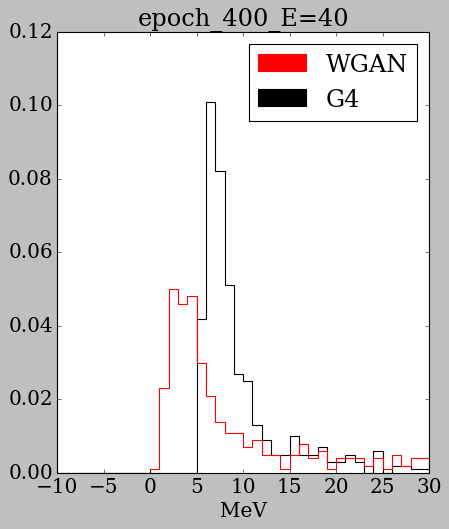

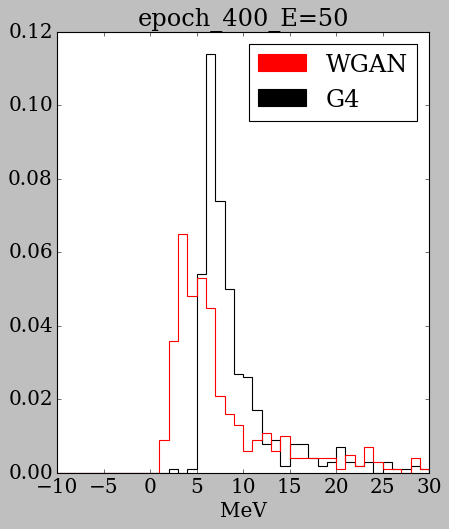

In [38]:
ngf = 32
nz=100
mGen = DCGAN_G(ngf, nz)
mGen = nn.parallel.DataParallel(mGen)
exp='wganv1'
batch_size = 1000


for eph in range(400,401): 
    gen_checkpoint = torch.load('/eos/user/e/eneren/experiments/' + exp + "_generator_"+ str(eph) + ".pt", map_location=torch.device('cpu'))
    mGen.load_state_dict(gen_checkpoint['model_state_dict'])
    mGen.eval()
    Tensor = torch.FloatTensor 
    z = Variable(Tensor(np.random.uniform(-1, 1, (batch_size, nz, 1, 1, 1))))
    
    jsd = []
    for e in [40, 50, 60]:
        
        enp = torch.from_numpy(np.random.uniform(e, e, (batch_size,1,1,1,1))).float()
        fake_data = mGen(z,enp).detach()
       
        esumFake = F.getTotE(fake_data.cpu().numpy(), 30, 30, 30)
        esumReal = F.getTotE(showers[str(e)], 30, 30, 30)
    
        esum_plot(esumReal, esumFake, 40, -10, 30, 'epoch_'+str(eph)+'_E='+str(e))
        
        jsd.append(F.jsdHist(esumReal, esumFake, 40, -10, 30, eph, debug=False))
        
    
    
    print ('Epoch {}: '.format(eph), jsd)
    #F.plot_image2D(fake_dataG)
    
    

In [ ]:
fake_dataG.shape

In [ ]:
F.plot_image2D(fake_dataG)